# Sequence Bucketing

Instead of clustering directly, we start by pre bucketing using a SAX like algorithm.
First we compress each sequence to `n` symbols and then quantize using k-means.

In [1]:
import yaml
import sys
import os 
import tensorflow as tf
sys.path.append('..')
import pickle
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from tensorflow.keras.models import *

import imp
import ml_pipeline
imp.reload(ml_pipeline)

<module 'ml_pipeline' from '../ml_pipeline/__init__.py'>

In [2]:
from ml_pipeline.audio import *
from ml_pipeline.dtw import * 
from ml_pipeline.sequence_hashing import *
from ml_pipeline.structured import * 
from ml_pipeline.audio_collection import * 

In [3]:
re          = RegionExtractors(0)
overlapping = []
for file in tf.io.gfile.listdir('../models/v3_lstm_v1/'):        
    if file.startswith("embedding") and file.endswith(".csv"):
        path = "{}/{}".format('../models/v3_lstm_v1/', file)
        print("\tReading {}".format(path))
        header                = ["filename", "start", "stop", "type", "embedding"]
        df                    = pd.read_csv(path, sep="\t", header = None, names=header)
        signals               = df[df['type'] >= 1]
        signals['embedding']  = df['embedding'].apply(
            lambda x: np.array([float(i) for i in x.split(",")]))
        annotated             = [(row['start'], row['stop'], row['filename'], row['embedding'])
                                 for _ , row in signals.iterrows()]
        overlapping += groupBy(annotated, re.overlap)    

	Reading ../models/v3_lstm_v1//embedding_06231101C.csv
	Reading ../models/v3_lstm_v1//embedding_072408Sb_RegPCa110.csv
	Reading ../models/v3_lstm_v1//embedding_07291101.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


	Reading ../models/v3_lstm_v1//embedding_061310Night_PCB110(UDDAS).csv
	Reading ../models/v3_lstm_v1//embedding_05250902_RegPCA110_new.csv
	Reading ../models/v3_lstm_v1//embedding_07141201 Canon.csv
	Reading ../models/v3_lstm_v1//embedding_05271102.csv
	Reading ../models/v3_lstm_v1//embedding_05311001 HD.csv
	Reading ../models/v3_lstm_v1//embedding_07050901_RegPCA110.csv
	Reading ../models/v3_lstm_v1//embedding_06261101.csv
	Reading ../models/v3_lstm_v1//embedding_07240804RegPca.csv
	Reading ../models/v3_lstm_v1//embedding_07030901.csv
	Reading ../models/v3_lstm_v1//embedding_07100601_RegPCA110_Part1.csv
	Reading ../models/v3_lstm_v1//embedding_08070801_RegPCA110.csv
	Reading ../models/v3_lstm_v1//embedding_06040602_RegPCA110.csv
	Reading ../models/v3_lstm_v1//embedding_05131201 XR.csv
	Reading ../models/v3_lstm_v1//embedding_081311N.csv
	Reading ../models/v3_lstm_v1//embedding_07280801_RegPCA110.csv
	Reading ../models/v3_lstm_v1//embedding_05200605_RegPCA110.csv
	Reading ../models/v3_

In [4]:
pickle.dump(overlapping, open('overlapping.pkl', 'wb'))

## Filtering size 

In [3]:
min_th = 1
max_th = 250
overlapping = [x for x in pickle.load(open('overlapping.pkl', 'rb'))]
lengths = [len(x[3]) for x in overlapping]
print(set(lengths))
overlapping = [x for x in overlapping if len(x[3]) > min_th and len(x[3]) < max_th]
sequences = [np.stack(s) for _, _, _, s in overlapping]
print(len(sequences), len(overlapping))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 116, 118, 119, 120, 7801, 122, 123, 124, 128, 130, 131, 133, 137, 138, 139, 140, 142, 143, 144, 145, 152, 154, 159, 163, 165, 172, 175, 178, 183, 184, 188, 189, 195, 203, 219, 234, 236}
44965 44965


## Bucket Result

In [5]:
assignments = similarity_bucketing(sequences, 4, 25)
clusters = max(assignments) + 1
print(clusters)

KeyboardInterrupt: 

In [5]:
counts = np.zeros(clusters)
for i in assignments:
    counts[i] += 1

Percentile 5:  1.5500000000000007
Percentile 10: 2.1000000000000014
Percentile 50: 56.0
Percentile 90: 541.5000000000002
Percentile 95: 957.1999999999975


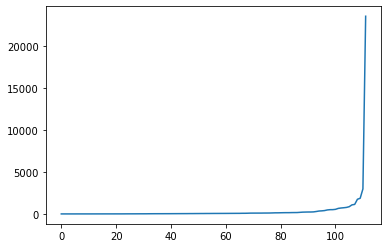

In [6]:
print("Percentile 5:  {}".format(np.percentile(counts, 5)))
print("Percentile 10: {}".format(np.percentile(counts, 10)))
print("Percentile 50: {}".format(np.percentile(counts, 50)))
print("Percentile 90: {}".format(np.percentile(counts, 90)))
print("Percentile 95: {}".format(np.percentile(counts, 95)))

plt.plot(sorted(counts))
plt.show()

In [7]:
by_assignment = {}
for o, s in zip(overlapping, assignments):
    if s not in by_assignment:
        by_assignment[s] = []
    by_assignment[s].append(o)

## Clustering In Each Bucket

+ Make this faster using all processors
+ https://wltrimbl.github.io/2014-06-10-spelman/intermediate/python/04-multiprocessing.html

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import multiprocessing as mp


def process(assignment, overlapping, max_dist = 1.0):
    n = len(overlapping)
    if n > 1:
        max_len = int(max([len(e) for _, _, _, e in overlapping]) + 1)
        dtw = DTW(max_len)
        dist = np.zeros((n, n))
        for i, (start_x, stop_x, f_x, embedding_x) in enumerate(overlapping):
            if i % 250 == 0 and i > 0:
                print("\t\t Processing: {} {}".format(i, len(overlapping)))
            for j, (start_y, stop_y, f_y, embedding_y) in enumerate(overlapping):
                if i < j:
                    x = np.array([embedding_x]).reshape(len(embedding_x), 256)
                    y = np.array([embedding_y]).reshape(len(embedding_y), 256)
                    d, _       = dtw.align(x, y) 
                    dist[i, j] = d / (len(x) * len(y))
                    dist[j, i] = d / (len(x) * len(y))
        print("\t {} {} {} {} {} {} ".format(assignment, n, np.percentile(dist.flatten(), 5), np.percentile(dist.flatten(), 95), np.mean(dist), np.std(dist)))
        agg = AgglomerativeClustering(n_clusters = None, 
                                      distance_threshold = max_dist, linkage = 'average', affinity='precomputed')
        clustering = agg.fit_predict(dist)
        return clustering, overlapping
    return [], []


pool = mp.Pool(processes=10)
results = [pool.apply_async(process, args=(assignment, overlapping, 1.0)) for assignment, overlapping in by_assignment.items()]
outputs = [p.get() for p in results]


with open('clustering.csv', "w") as fp:
    cur = 0
    for clustering, overlapping in outputs:
        if len(clustering) > 0:
            for c, (start, stop, f, _) in zip(clustering, overlapping):
                fp.write("{},{},{},{}\n".format(start, stop, f, c + cur))
            for c in range(len(set(clustering))):
                cur += 1

In [3]:
df = pd.read_csv('clustering.csv', names=['start', 'stop', 'file', 'clusters'], header = None)

Clusters: 16447


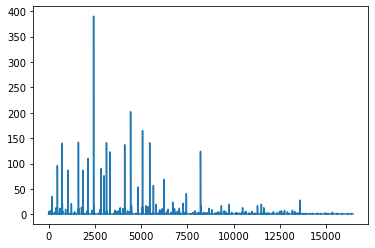

In [4]:
grouped_by_filename = {}
# instance id
clusters = []
for i, row in df.iterrows():
    start = row[0]
    stop = row[1]
    f = row[2]
    c = row[3]
    
    if f not in grouped_by_filename:
        grouped_by_filename[f] = []
    grouped_by_filename[f].append((start, stop, c, i))
    clusters.append(c)
    
k = max(clusters) + 1
instances_clusters = np.zeros(k)
for c in clusters:
    instances_clusters[c] += 1
    
print("Clusters: {}".format(k))
plt.plot(instances_clusters)
plt.show()

In [5]:
import multiprocessing as mp

out = "../models/v2_lstm_v8"

def write_audio(cluster_id, instances_clusters, grouped_by_filename, min_support):
    if instances_clusters[cluster_id] > min_support:
        print("Audio result for cluster: {} {}".format(cluster_id, instances_clusters[cluster_id]))
        audio_bank = AudioSnippetCollection("{}/seq_cluster_{}.wav".format(out, cluster_id))
        for f, regions in grouped_by_filename.items():
            snippets        = [(start, stop) for start, stop, _, _ in regions]
            cluster_snippet = [c for _, _, c,_ in regions] 
            for audio_snippet, c in zip(audio_regions(f, snippets), cluster_snippet):
                if c == cluster_id:
                    audio_bank.write(audio_snippet)
        audio_bank.close()
        print("Done: {}".format(cluster_id))
        
pool = mp.Pool(processes=10)
results = [pool.apply_async(write_audio, args=(cluster_id, instances_clusters, grouped_by_filename, 10)) for cluster_id in range(0, k)]
outputs = [p.get() for p in results]

Audio result for cluster: 177 22.0
Audio result for cluster: 179 35.0
Audio result for cluster: 408 13.0
Audio result for cluster: 475 11.0
Audio result for cluster: 477 96.0
Audio result for cluster: 614 12.0
Audio result for cluster: 736 140.0
Audio result for cluster: 737 11.0
Audio result for cluster: 746 22.0
Audio result for cluster: 1041 13.0
Audio result for cluster: 1042 87.0
Audio result for cluster: 1233 21.0
Audio result for cluster: 1614 142.0
Audio result for cluster: 1624 12.0
Audio result for cluster: 1781 14.0
Audio result for cluster: 1863 87.0
Audio result for cluster: 2131 110.0
Audio result for cluster: 2435 390.0
Audio result for cluster: 2437 12.0
Audio result for cluster: 2444 19.0


NameError: name 'println' is not defined

Audio result for cluster: 2842 90.0
Audio result for cluster: 2997 76.0
Audio result for cluster: 3131 141.0
Audio result for cluster: 3135 15.0
Audio result for cluster: 3312 123.0
Audio result for cluster: 3316 11.0
Audio result for cluster: 3872 13.0
Audio result for cluster: 4006 11.0
Audio result for cluster: 4100 12.0
Audio result for cluster: 4114 137.0
Audio result for cluster: 4434 202.0
Audio result for cluster: 4461 12.0
Audio result for cluster: 4482 17.0
Audio result for cluster: 4843 54.0
Audio result for cluster: 5072 15.0
Audio result for cluster: 5079 165.0
Audio result for cluster: 5274 17.0
Audio result for cluster: 5374 15.0
Audio result for cluster: 5459 15.0
Audio result for cluster: 5466 141.0
Audio result for cluster: 5666 57.0
Audio result for cluster: 5665 18.0
Audio result for cluster: 5818 20.0
Audio result for cluster: 6140 11.0
Audio result for cluster: 6225 69.0
Audio result for cluster: 6709 24.0
Audio result for cluster: 6808 11.0
Audio result for clust

In [ ]:
for cluster_id in range(0, k):
    for f, regions in grouped_by_filename.items():
        filename = f.split(".")[0].split("/")[-1]
        log_path = "{}/seq_clustering_log_{}.csv".format(out, filename)
        #instance id
        with open(log_path, "a+") as fp:
            for start, stop, c, i in regions:
                if c == cluster_id:
                    fp.write("{},{},{},{},{}\n".format(start, stop, f, c, i))                        